# Transformer LM

Minimal implemention of transformer model

In [ ]:
#| default_exp models.transformer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

# torch
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import SGD
# from torchtext.vocab import vocab

# hf
import datasets

# data 
import pandas as pd
import numpy as np

# ui
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# python
from typing import Dict, List, Tuple, Optional, Set
from collections import Counter, OrderedDict
from dataclasses import dataclass, asdict
from plum import dispatch

# nimrod
from nimrod.models.lm import Vocab
from nimrod.utils import get_device

In [ ]:
device = get_device()
print(device)

mps


## Data formatting
- https://buomsoo-kim.github.io/attention/2020/04/21/Attention-mechanism-19.md/


In [ ]:
# dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')

In [ ]:
# print(dataset['train'][88])

read each line of text data into a dataframe row

In [ ]:
# read unstructured text into pd
df = pd.read_fwf('../data/text/tiny_shakespeare.txt', header=None)
print("Dataframe: ", df.head(2))
sentences = df[0].tolist()
print("List: ", sentences[:2])
v = Vocab(sentences)
print("Vocab: ", len(v), ''.join(v.vocabulary))

Dataframe:                                                 0
0                                 First Citizen:
1  Before we proceed any further, hear me speak.
List:  ['First Citizen:', 'Before we proceed any further, hear me speak.']
Vocab:  68  !$&',-.3:;<bos><eos><pad><unk>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


transform data into one long string where each row is separated par blank

In [ ]:
# squash list of sentences into one large list of characters
data = []
for line in sentences:
    data.extend(line + ' ')
print(data[:100])


['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', ' ', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', ' ', 'A', 'l', 'l', ':', ' ', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', ' ', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', ' ', 'Y', 'o', 'u', ' ', 'a']


create validation and training set

In [ ]:
n = len(data)
train = data[:int(n*0.9)]
val = data[int(n*0.9):]
print(val[:25])


['e', ' ', 'b', 'a', 'r', 'e', '-', 'f', 'o', 'o', 't', ' ', 'o', 'n', ' ', 'h', 'e', 'r', ' ', 'w', 'e', 'd', 'd', 'i', 'n']


Create X and Y training pairs of size "context length" 

In [ ]:
context_length = 3
x = data[:context_length]
y = data[1:context_length+1]
print(x, y)
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(context, target)

['F', 'i', 'r'] ['i', 'r', 's']
['F'] i
['F', 'i'] r
['F', 'i', 'r'] s


In [ ]:
ids = v.stoi(data)


In [ ]:
print(ids[:10])
print(v.itos(ids[:10]))

[52, 13, 11, 10, 6, 4, 40, 13, 6, 13]
['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i']


Randomize the data sets

In [ ]:
def get_random_batch(token_sequence, context_length, batch_size, device=device):
    ix = torch.randint(len(token_sequence) - context_length, (batch_size,)) # max index is (L - context_length)
    x = torch.stack([token_sequence[i:i+context_length] for i in ix])
    y = torch.stack([token_sequence[i+1:i+1+context_length] for i in ix])
    return (x.to(device),y.to(device))

create training batch

In [ ]:
context_length = 10
batch_size = 8
x, y = get_random_batch(torch.LongTensor(ids), context_length, batch_size)
print(f'Batches X: {x.shape}, Y: {y.shape}')
for i in range(batch_size):
    # v.itos(int(x[i]))
    print('X: ', [v.itos(int(el)) for el in x[i]])
    print('Y: ', [v.itos(int(el)) for el in y[i]])


Batches X: torch.Size([8, 10]), Y: torch.Size([8, 10])
X:  [' ', 'D', 'E', 'R', 'B', 'Y', ':', ' ', 'I', ' ']
Y:  ['D', 'E', 'R', 'B', 'Y', ':', ' ', 'I', ' ', 'p']
X:  ['b', 'e', ' ', 'r', 'e', 's', 't', 'r', 'a', 'i']
Y:  ['e', ' ', 'r', 'e', 's', 't', 'r', 'a', 'i', 'n']
X:  ['y', 'o', 'u', ' ', 'c', 'a', 'n', ',', ' ', 'p']
Y:  ['o', 'u', ' ', 'c', 'a', 'n', ',', ' ', 'p', 'a']
X:  [' ', 'p', 'e', 'r', 'p', 'e', 't', 'u', 'a', 'l']
Y:  ['p', 'e', 'r', 'p', 'e', 't', 'u', 'a', 'l', ' ']
X:  ['l', 'o', 'r', 'd', ';', ' ', 'f', 'o', 'r', ' ']
Y:  ['o', 'r', 'd', ';', ' ', 'f', 'o', 'r', ' ', 't']
X:  [' ', 'M', 'o', 'r', 'e', ' ', 'g', 'r', 'a', 'v']
Y:  ['M', 'o', 'r', 'e', ' ', 'g', 'r', 'a', 'v', 'e']
X:  ['o', 'n', ' ', 't', 'o', 'w', 'a', 'r', 'd', 's']
Y:  ['n', ' ', 't', 'o', 'w', 'a', 'r', 'd', 's', ' ']
X:  ['n', 't', 'l', 'e', 'n', 'e', 's', 's', ',', ' ']
Y:  ['t', 'l', 'e', 'n', 'e', 's', 's', ',', ' ', 'K']


## Attention

In [ ]:
#| export

class AttentionHead(nn.Module):
    """ self attention head """
    def __init__(self, n_embd, head_size, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [ ]:
vocab_size = 10
batch_size = 5
embed_dim = 20
context_size = 8
dropout = 0.2
head_size = 16
# embedded input (float)
x = torch.randn(batch_size, context_size, embed_dim) #(B,T,C)
print(x.shape)
att = AttentionHead(embed_dim, head_size, context_size, dropout)
xx = att(x)
print(xx.shape)

torch.Size([5, 8, 20])
torch.Size([5, 8, 16])


In [ ]:
#| export

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(n_embd, head_size, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
num_heads = 3
multi_att = MultiHeadAttention(num_heads, head_size, embed_dim, context_size, dropout)
xxx = multi_att(x)
print(xxx.shape)

torch.Size([5, 8, 20])


## Feed forward

In [ ]:
#| export 

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
ff = FeedFoward(embed_dim, dropout)
ff_x = ff(x)
print(ff_x.shape)

torch.Size([5, 8, 20])


## Block

In [ ]:
#| export 

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head

        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
b = Block(embed_dim, num_heads, context_length, dropout)
bb = b(x)
print(bb.shape)

torch.Size([5, 8, 20])


## GPT model

In [ ]:
#| export

class GPTLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, device='cuda'):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
eval_interval = 500
learning_rate = 3e-4
device = get_device()
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size = len(v)
m = GPTLanguageModel(vocab_size, n_embd, block_size, n_head, n_layer, dropout)

In [ ]:
print(device)

mps


In [ ]:
device = torch.device('mps')
m = m.to(device)
x = torch.randint(vocab_size, (batch_size, block_size)).to(device)
logits, loss = m(x)
# print(logits.shape)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# @torch.no_grad()
# def estimate_loss():
#     out = {}
#     model.eval()
#     for split in ['train', 'val']:
#         losses = torch.zeros(eval_iters)
#         for k in range(eval_iters):
#             X, Y = get_batch(split)
#             logits, loss = model(X, Y)
#             losses[k] = loss.item()
#         out[split] = losses.mean()
#     model.train()
#     return out

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
acc_loss = []
max_iters = 1
for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_random_batch(torch.LongTensor(ids), block_size, batch_size, device=device)

    # evaluate the loss
    logits, loss = m(xb.to(device), yb.to(device))
    print(loss.item())
    acc_loss.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

2.1705524921417236
2.950320243835449
2.371941328048706
2.4078457355499268
2.359858512878418
2.304844379425049
2.3548460006713867
2.318650007247925
2.296562910079956
2.2918810844421387


[<matplotlib.lines.Line2D>]

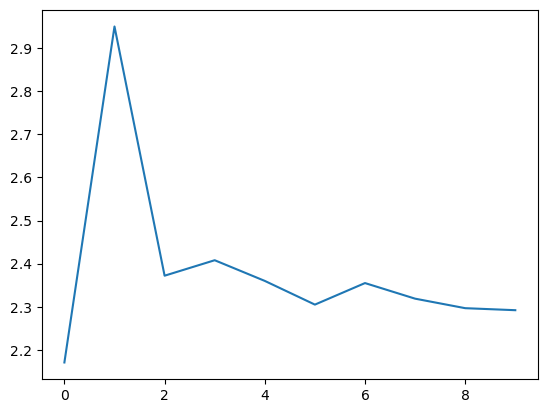

In [ ]:
plt.plot(acc_loss)

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(''.join(v.itos(m.generate(context, max_new_tokens=50)[0].tolist())))

<pad>imerr otho ne the miouetwhe of ooureshart APlate L


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()